In [6]:
# imports
import numpy as np
from facenet_pytorch import MTCNN, InceptionResnetV1
from gan import Generator, Discriminator, GAN
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import pdb
import torch
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# instantiate generator and discriminator
generator = Generator()
discriminator = Discriminator()

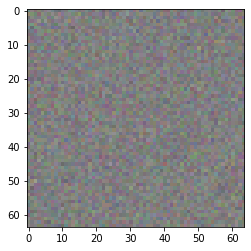

In [3]:
# display sample of untrained generator output
mask = generator()
plt.figure()
plt.imshow(mask.detach().numpy())
plt.savefig('../figures/gan_output.png')
plt.show()

<Figure size 432x288 with 0 Axes>

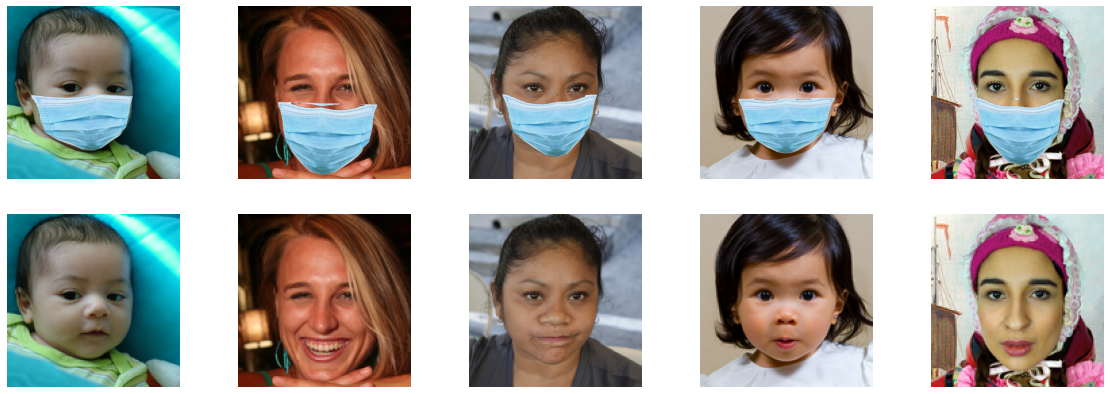

In [4]:
# load masked and unmasked faces
num_faces = 500
masked_faces = torch.zeros((num_faces, 3, 128, 128))
unmasked_faces = torch.zeros((num_faces, 3, 128, 128))
plt.figure()
fig, axes = plt.subplots(2, 5)
fig.set_figwidth(20)
fig.set_figheight(7)
mtcnn = MTCNN(image_size=128)
face_id = 0
skipped = 0
while face_id < num_faces:
    # get image paths
    face_id_text = str(100000 + face_id + skipped)[1:]
    masked_path = '../data/masked/{}_Mask.jpg'.format(face_id_text)
    unmasked_path = '../data/unmasked/{}.png'.format(face_id_text)
    
    # load and display images
    try:  # skip missing mask images
        masked_img = Image.open(masked_path)
    except:
        skipped += 1
        continue
    unmasked_img = Image.open(unmasked_path)
    if face_id < 5:
        axes[0,face_id].imshow(masked_img)
        axes[0,face_id].set_axis_off()
        axes[1,face_id].imshow(unmasked_img)
        axes[1,face_id].set_axis_off()
        
    # skip images that MTCNN can't process
    if mtcnn(masked_img) is None or mtcnn(unmasked_img) is None:
        skipped += 1
        continue
    
    # process and save images into respective tensors
    masked_faces[face_id] = mtcnn(masked_img)
    unmasked_faces[face_id] = mtcnn(unmasked_img)
    face_id += 1
    
plt.savefig('../figures/sample_faces.png')

In [5]:
# calculate embeddings for masked and unmasked images
unmasked_embeddings = discriminator(unmasked_faces)
masked_embeddings = discriminator(masked_faces)

# determined masked accuracy
unmasked_embeddings = torch.unsqueeze(unmasked_embeddings, 1)
masked_embeddings = torch.unsqueeze(masked_embeddings, 0)
distances = torch.norm(unmasked_embeddings - masked_embeddings, dim=2)
classifications = torch.argmin(distances, dim=0)
masked_accuracy = sum(classifications == torch.Tensor([ i for i in range(num_faces) ])) / num_faces
print('facial recognition accuracy for masked images: {:.1f}%'.format(100 * masked_accuracy))

# determine unmasked accuracy
unmasked_embeddings_alt = torch.unsqueeze(torch.squeeze(unmasked_embeddings), 0)
distances = torch.norm(unmasked_embeddings - unmasked_embeddings_alt, dim=2)
classifications = torch.argmin(distances, dim=0)
unmasked_accuracy = sum(classifications == torch.Tensor([ i for i in range(num_faces) ])) / num_faces
print('facial recognition accuracy for unmasked images: {:.1f}%'.format(100 * unmasked_accuracy))

facial recognition accuracy for masked images: 85.2%
facial recognition accuracy for unmasked images: 100.0%


<Figure size 432x288 with 0 Axes>

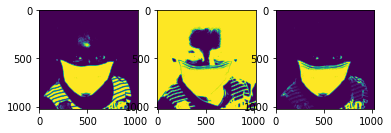

In [37]:
# read image channels
image = cv2.imread('../data/masked/00010_Mask.jpg')
blue = image[:,:,0]
green = image[:,:,1]
red = image[:,:,2]

# threshold lower bound
_, blue_lo = cv2.threshold(blue, 150, 1, cv2.THRESH_BINARY)
_, green_lo = cv2.threshold(green, 50, 1, cv2.THRESH_BINARY)
_, red_lo = cv2.threshold(red, 30, 1, cv2.THRESH_BINARY)

# threshold upper bound
_, blue_up = cv2.threshold(blue, 255, 1, cv2.THRESH_BINARY_INV)
_, green_up = cv2.threshold(green, 230, 1, cv2.THRESH_BINARY_INV)
_, red_up = cv2.threshold(red, 215, 1, cv2.THRESH_BINARY_INV)

# combine threshold masks
lower_bound = blue_lo * green_lo * red_lo
upper_bound = blue_up * green_up * red_up
combo = lower_bound * upper_bound
plt.figure()
fig, axes = plt.subplots(1, 3)
axes[0].imshow(lower_bound)
axes[1].imshow(upper_bound)
axes[2].imshow(combo)
plt.show()